# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This project is to build a traffic sign classifier based on [LeNet](http://yann.lecun.com/exdb/lenet/)

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

label_with_names = np.genfromtxt('signnames.csv', skip_header=1, dtype=[('myint','i8'), ('mysring','S55')], delimiter=',')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

37


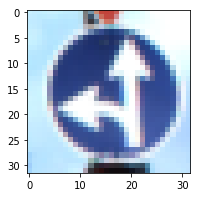

In [3]:
# Visualization of the random picture
import matplotlib.pyplot as plt
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index]


plt.figure(figsize=(10,3))
plt.imshow(image)
print(y_train[index])

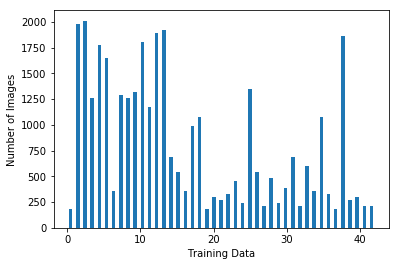

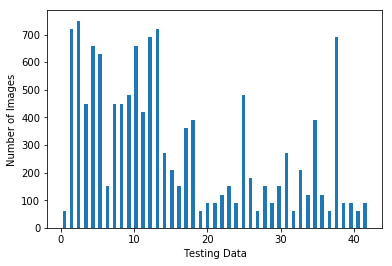

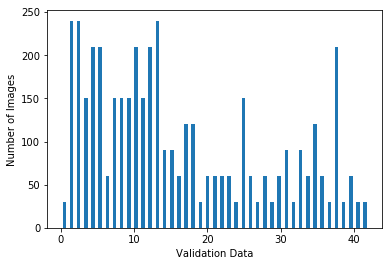

In [60]:
# Visualization of the label informations

def histogram_graph(data, label):
    hist, bin_edges = np.histogram(data, bins=43)
    width = 0.5 * (bin_edges[1] - bin_edges[0])
    center = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Number of Images")
    plt.show()

histogram_graph(y_train, "Training Data")
histogram_graph(y_test, "Testing Data")
histogram_graph(y_valid, "Validation Data")    


----

## Step 2: Design and Test a Model Architecture

The original LeNet was described by this paper:
Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, november 1998.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), which maybe a direction of the future improvment. 

### Pre-process the Data Set (normalization, grayscale)

Speed limit (80km/h)


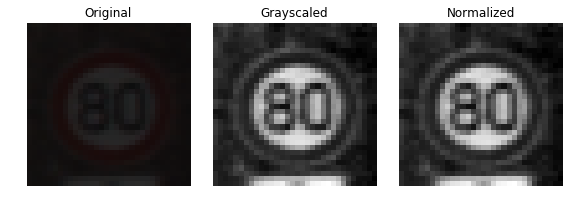

In [4]:
### Preprocess the data here. 

import cv2

X_train_original = X_train
X_test_original = X_test
X_valid_original = X_valid

# Convert to grayscale image
X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)
X_test_gray = np.sum(X_test/3, axis=3, keepdims=True)
X_valid_gray = np.sum(X_valid/3, axis=3, keepdims=True)

# X_train_gray = np.zeros((len(X_train),32,32))
# X_test_gray = np.zeros((len(X_test),32,32))
# X_valid_gray = np.zeros((len(X_valid),32,32))

# for i in range(len(X_train)):
    # X_train_gray[i] = (cv2.cvtColor(X_train[i],cv2.COLOR_RGB2GRAY))

# for i in range(len(X_test)):
    # X_test_gray[i] = (cv2.cvtColor(X_test[i],cv2.COLOR_RGB2GRAY))
    
# for i in range(len(X_valid)):
    # X_valid_gray[i] = (cv2.cvtColor(X_valid[i],cv2.COLOR_RGB2GRAY))
    
# Normalization fo the data. So the data has similar mean value and varience
X_train_normalized = (X_train_gray-128)/128
X_test_normalized = (X_test_gray-128)/128
X_valid_normalized = (X_valid_gray-128)/128

index = random.randint(0, len(X_train))
image = X_train[index]
image_normalized = X_train_normalized[index].squeeze()
image_gray = X_train_gray[index].squeeze()

# Plotting a random example
n_rows = 1
n_cols = 3
offset = 9000
fig, axs = plt.subplots(n_rows,n_cols, figsize=(10, 3))
fig.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Original')
axs[0].imshow(image)

axs[1].axis('off')
axs[1].set_title('Grayscaled')
axs[1].imshow(image_gray,cmap='gray')

axs[2].axis('off')
axs[2].set_title('Normalized')
axs[2].imshow(image_normalized,cmap='gray')



label_decoded= label_with_names[y_train[index]][1].decode('ascii')
print(label_decoded)


### Model Architecture

In [5]:


import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 30
BATCH_SIZE = 100



from tensorflow.contrib.layers import flatten

# LeNet Architecture
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [6]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

from sklearn.utils import shuffle

### Define the variables in the pipeline for convient purpose
X_train = X_train_normalized
X_test = X_test_normalized
X_valid = X_valid_normalized

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

## Training pipeline
rate = 0.0009

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Define evaluation function

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [6]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.600

EPOCH 2 ...
Validation Accuracy = 0.787

EPOCH 3 ...
Validation Accuracy = 0.868

EPOCH 4 ...
Validation Accuracy = 0.882

EPOCH 5 ...
Validation Accuracy = 0.891

EPOCH 6 ...
Validation Accuracy = 0.916

EPOCH 7 ...
Validation Accuracy = 0.927

EPOCH 8 ...
Validation Accuracy = 0.933

EPOCH 9 ...
Validation Accuracy = 0.945

EPOCH 10 ...
Validation Accuracy = 0.936

EPOCH 11 ...
Validation Accuracy = 0.949

EPOCH 12 ...
Validation Accuracy = 0.943

EPOCH 13 ...
Validation Accuracy = 0.944

EPOCH 14 ...
Validation Accuracy = 0.953

EPOCH 15 ...
Validation Accuracy = 0.954

EPOCH 16 ...
Validation Accuracy = 0.961

EPOCH 17 ...
Validation Accuracy = 0.954

EPOCH 18 ...
Validation Accuracy = 0.956

EPOCH 19 ...
Validation Accuracy = 0.962

EPOCH 20 ...
Validation Accuracy = 0.959

EPOCH 21 ...
Validation Accuracy = 0.960

EPOCH 22 ...
Validation Accuracy = 0.956

EPOCH 23 ...
Validation Accuracy = 0.960

EPOCH 24 ...
Validation Accura

In [7]:
## Evaluate the model

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.940


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [7]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np
import cv2

### Predict the Sign Type for Each Image

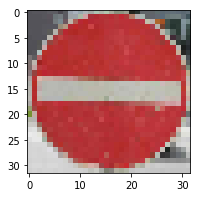

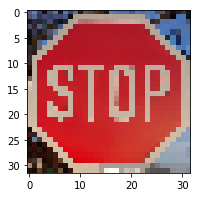

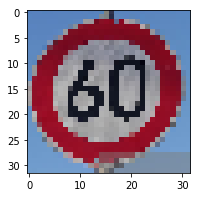

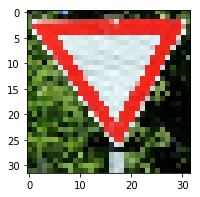

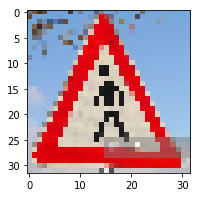

In [8]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

import glob
import matplotlib.image as mpimg
image_list_png = glob.glob('mySigns/*.png')
image_list_jpg = glob.glob('mySigns/*.jpg')

my_images = []

#if image_list is not None:
    #for img in image_list:
        #image = plt.imread(img)
        #plt.figure(figsize=(10,3))
        #plt.imshow(image)
        #my_images.append(image)
        
if image_list_jpg is not None:
    for image in image_list_jpg:
        img = cv2.imread(image)
        img = cv2.resize(img, (32,32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        my_images.append(img)
        plt.figure(figsize=(10,3))
        plt.imshow(img)
        


my_images = np.asarray(my_images)   

my_images_gry = np.sum(my_images/3, axis=3, keepdims=True)

my_images_normalized = (my_images_gry - 128)/128 

# my_labels_png = [1, 3, 38, 34, 25, 18]

my_labels_jpg = [17, 14, 3, 13, 27]


# plt.figure(figsize=(10,3))
# plt.imshow(my_images_gry[0].squeeze())
# print(my_images_gry.shape)


### Analyze Performance

In [10]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./lenet.meta')
    saver3.restore(sess, "./lenet")
    test_accuracy = evaluate(my_images_normalized, my_labels_jpg)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.600


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./lenet
For sign 0  guess 0 is: 17 , with probability 100% . The label should be 17
For sign 0  guess 1 is: 33 , with probability 0% . The label should be 17
For sign 0  guess 2 is: 14 , with probability 0% . The label should be 17
For sign 0  guess 3 is: 34 , with probability 0% . The label should be 17
For sign 0  guess 4 is: 0 , with probability 0% . The label should be 17


This is a wrong guess!!
For sign 1  guess 0 is: 25 , with probability 74% . The label should be 14
For sign 1  guess 1 is: 18 , with probability 21% . The label should be 14
For sign 1  guess 2 is: 29 , with probability 2% . The label should be 14
For sign 1  guess 3 is: 14 , with probability 1% . The label should be 14
For sign 1  guess 4 is: 39 , with probability 1% . The label should be 14


This is a wrong guess!!
For sign 2  guess 0 is: 1 , with probability 100% . The label should be 3
For sign 2  guess 1 is: 2 , with probability 0% . The label should be 3
For sign 

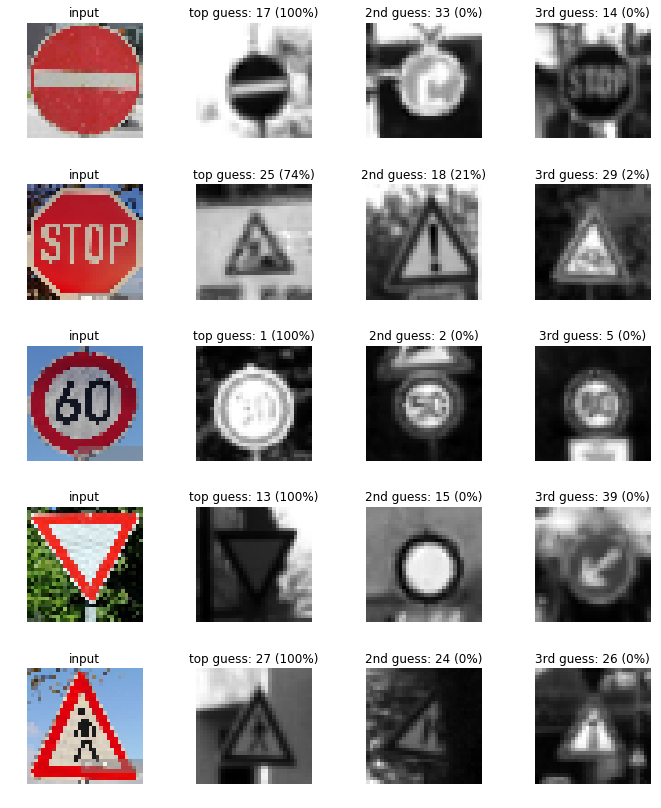

In [53]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(tf.nn.softmax(logits), feed_dict={x: my_images_normalized, keep_prob: 1.0})
    top_guess = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: my_images_normalized, keep_prob: 1.0})

    for i in range(5):
        if (top_guess[1][i][0]!=my_labels_jpg[i]):
                print("This is a wrong guess!!")
        for j in range(5):
            print('For sign',i,' guess',j, 'is:', top_guess[1][i][j], \
                  ', with probability {:.0%}'.format(top_guess[0][i][j]),'. The label should be', \
                 my_labels_jpg[i])
        print('\n')
    
#### Plotting method is from Jeremy Shannon 
#### https://github.com/jeremy-shannon/CarND-Traffic-Sign-Classifier-Project
    fig, axs = plt.subplots(len(my_images),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.05)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(image)
        axs[4*i].set_title('input')
        guess1 = top_guess[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_valid[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*top_guess[0][i][0]))
        guess2 = top_guess[1][i][1]
        index2 = np.argwhere(y_valid == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_valid[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*top_guess[0][i][1]))
        guess3 = top_guess[1][i][2]
        index3 = np.argwhere(y_valid == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_valid[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*top_guess[0][i][2]))

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [12]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")